In [1]:
# ДЗ
# 1. Подберите парамтеры алгоритма разрастания регионов так, чтобы был выделен весь участок газона.
# 2. Реализуйте вычисление критерия однородности, отличного от представленного. Сравните результаты.
# 3. Применить алгоритм сегментации watershed+distance transform для задачи подсчета пальмовых деревьев

import numpy as np
import cv2
import matplotlib.pyplot as plt

# 1. Алгоритм разрастания региона 
# 2. Функции вычисления критерия онородности

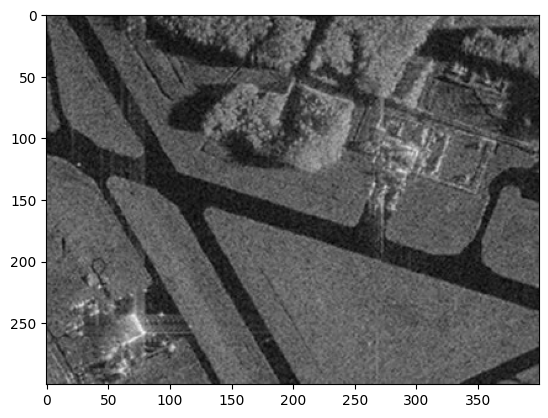

In [2]:
image = cv2.imread('sar_1.jpg')
image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
plt.imshow(image_gray, cmap="gray")

In [3]:
import math
def homo_average(img, mask, point, T):
    av_val = img[mask > 0].sum() / np.count_nonzero(img[mask > 0]) #mean
    if abs(av_val - img[point]) <= T:
        return True
    return False

def homo_median(img, mask, point, T):
    region_pixels = img[mask > 0]
    if region_pixels.size == 0:
        return False
    median_val = np.median(region_pixels)
    pixel_val = img[point]
    return abs(median_val - pixel_val) <= T

def region_growing(image, seed_point,homo_fun,r, T):
    mask = np.zeros(image_gray.shape, np.uint8)
    mask[seed_point] = 1
    count = 1
    while count > 0:
        count = 0
        local_mask = np.zeros(image_gray.shape, np.uint8)
        for i in range(r,image.shape[0] - r):
            for j in range(r,image.shape[1] - r):
                if mask[i,j]==0 and mask[i - r:i + r, j-r: j+r].sum() > 0:
                    if homo_fun(image, mask, (i,j), T):
                        local_mask[i,j] = 1
        count = np.count_nonzero(local_mask)
        # print(count)
        mask += local_mask
        
    return mask*255

In [4]:
seed_point = (250,250)
mask_0 = region_growing(image_gray,seed_point, homo_average, 5, 20)
mask_1 = region_growing(image_gray,seed_point, homo_median, 5, 20)


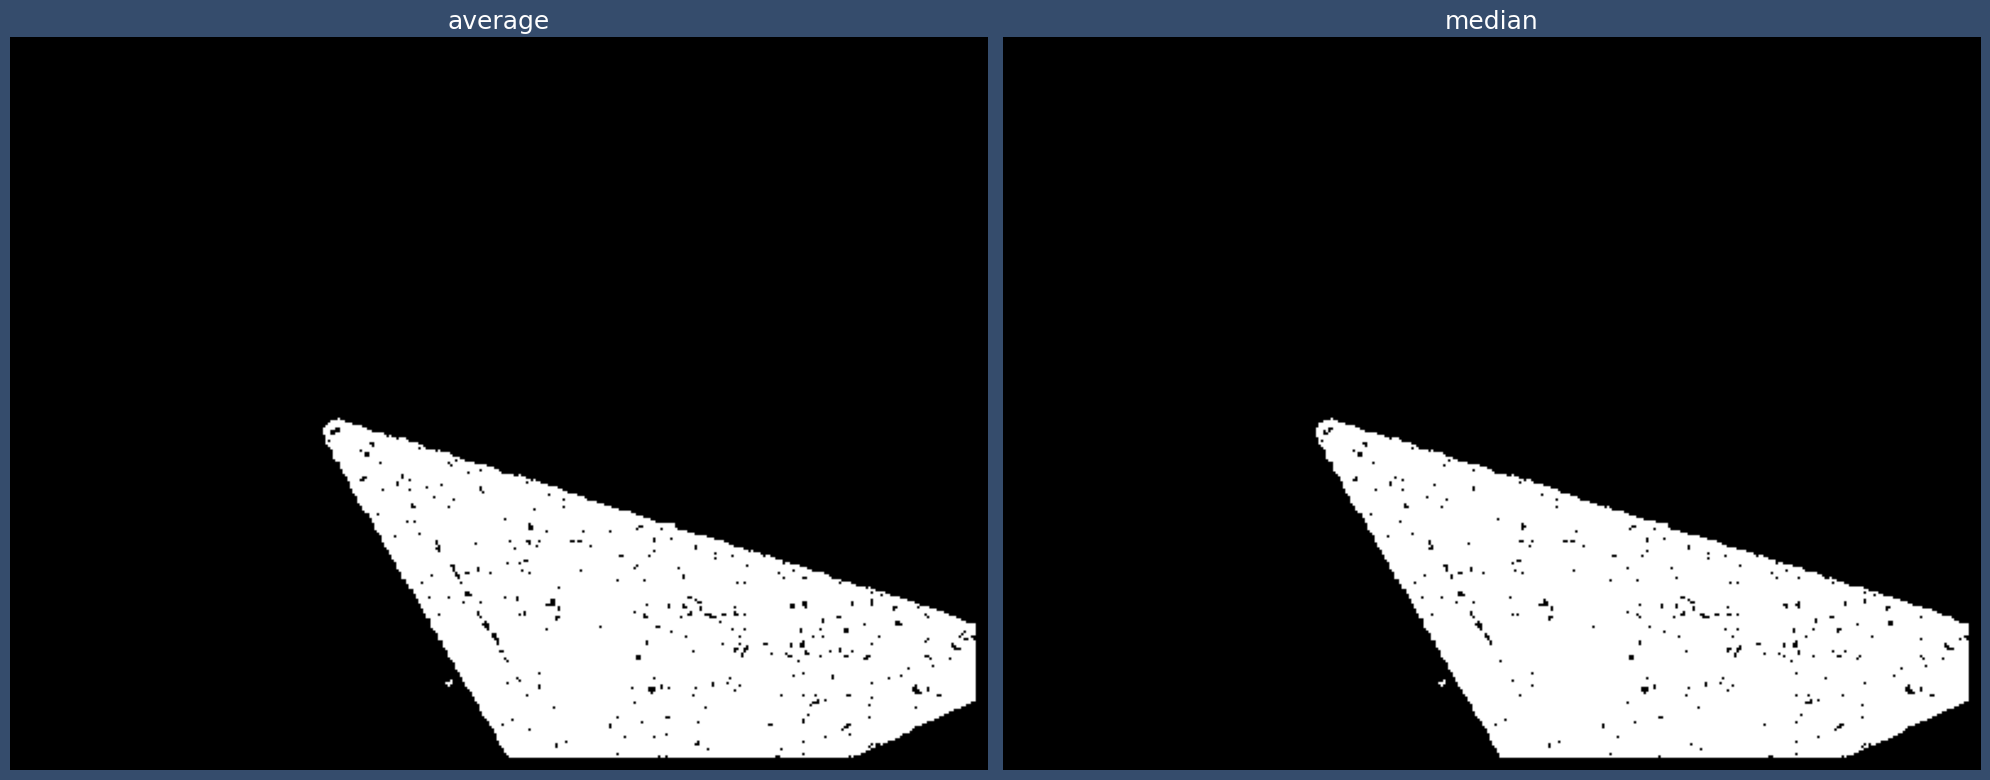

Разницы между результатами функции среднего и функции медианного почти нет.
T достаточно велико, чтобы оба метода допустили расширение области одинаково


In [5]:
plt.figure(figsize=(20, 10), facecolor='#354c6c')

plt.subplot(1, 2, 1)
plt.title('average', color='white', fontsize=18)
plt.axis('off')
plt.imshow(mask_0, cmap='gray')

plt.subplot(1, 2, 2)
plt.title('median', color='white', fontsize=18)
plt.axis('off')
plt.imshow(mask_1, cmap='gray')

plt.tight_layout()
plt.show()

print("Разницы между результатами функции среднего и функции медианного почти нет.\nT достаточно велико, чтобы оба метода допустили расширение области одинаково")

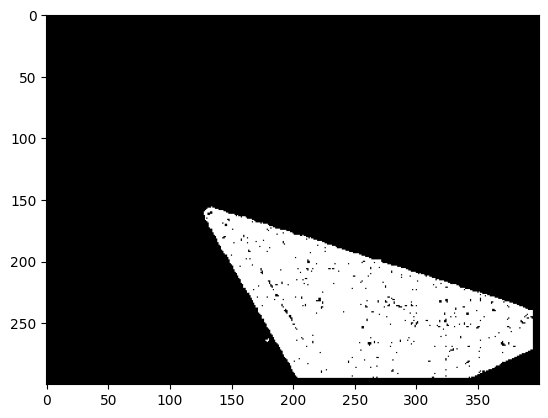

In [6]:
import numpy as np

def homo_stddev(img, mask, point, T):
    region_pixels = img[mask > 0]
    if region_pixels.size == 0:
        return False
    stddev = region_pixels.std()
    pixel_val = img[point]
    return abs(np.mean(region_pixels) - pixel_val) <= T and stddev <= T

mask_2 = region_growing(image_gray, seed_point, homo_stddev, 5, 20)

plt.imshow(mask_2, cmap='gray')

# 3. Алгоритмы сегментации для подсчета объектов на изображении.

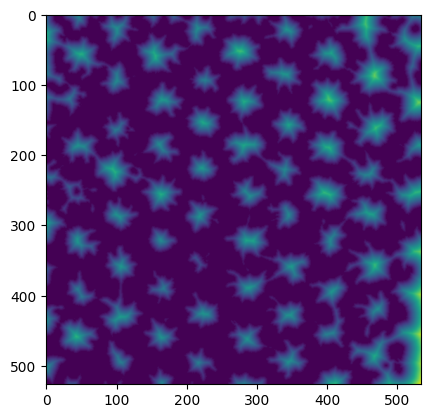

In [7]:
img = cv2.imread('palm_1.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)


blurred = cv2.bilateralFilter(gray,15,150,150)

_, thresh = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
# plt.imshow(thresh, cmap='gray')

dist = cv2.distanceTransform(thresh, cv2.DIST_L2, 5) 
plt.imshow(dist)

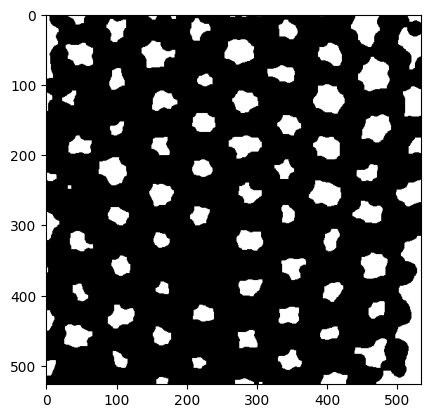

In [8]:
ret, sure_fg = cv2.threshold(dist, 0.25 * dist.max(), 255, cv2.THRESH_BINARY)
sure_fg = sure_fg.astype(np.uint8)

kernel = np.ones((3, 3), np.uint8)
sure_fg = cv2.morphologyEx(sure_fg, cv2.MORPH_OPEN, kernel)
sure_fg = cv2.dilate(sure_fg, kernel, iterations=1)

plt.imshow(sure_fg, cmap='gray')

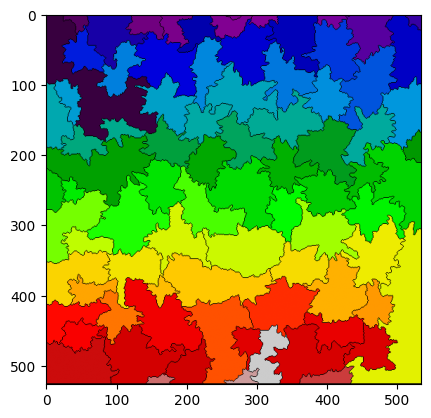

In [9]:
ret, markers = cv2.connectedComponents(sure_fg)
markers = cv2.watershed(img, markers)
plt.imshow(markers,cmap='nipy_spectral')

Приблизительное количество пальм: 83


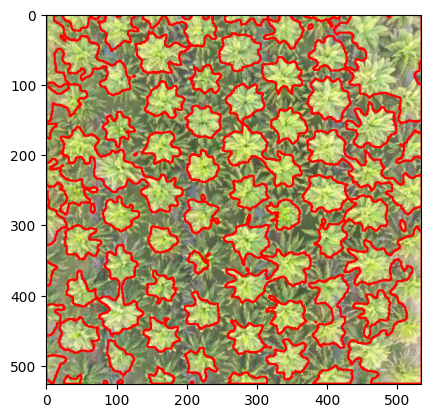

In [10]:
contour_image = img.copy()
contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cv2.drawContours(contour_image, contours, -1, (255, 0, 0), 2) 

plt.imshow(contour_image)

print(f"Приблизительное количество пальм: {ret - 1}")